# 21 - Word2Vec

by [Alejandro Correa Bahnsen](http://www.albahnsen.com/)

version 1.0, July 2018

## Part of the class [Applied Deep Learning](https://github.com/albahnsen/AppliedDeepLearningClass)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). 

# Word2Vec

Word2vec is a two-layer neural net that processes text. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep nets can understand. 

Word2vec’s applications extend beyond parsing sentences in the wild. It can be applied just as well to genes, code, likes, playlists, social media graphs and other verbal or symbolic series in which patterns may be discerned.

Why? Because words are simply discrete states like the other data mentioned above, and we are simply looking for the transitional probabilities between those states: the likelihood that they will co-occur. So gene2vec, like2vec and follower2vec are all possible. With that in mind, the tutorial below will help you understand how to create neural embeddings for any group of discrete and co-occurring states.

The purpose and usefulness of Word2vec is to group the vectors of similar words together in vectorspace. That is, it detects similarities mathematically. Word2vec creates vectors that are distributed numerical representations of word features, features such as the context of individual words. It does so without human intervention.

# Tensorflow Hub

TensorFlow Hub is a library for the publication, discovery, and consumption of reusable parts of machine learning models. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning. Transfer learning can:

- Train a model with a smaller dataset,
- Improve generalization, and
- Speed up training.

In [1]:
!pip install tensorflow-hub

    100% |████████████████████████████████| 61kB 416kB/s ta 0:00:011
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

See available modules on tensor_flow_hub

https://www.tensorflow.org/hub/modules/text

In [30]:
hub_model = "https://tfhub.dev/google/Wiki-words-250/1"

In [60]:

def create_text_embedding(hub_model, input_sentences):
        
    SEQ_LENGTH = max(map(len, input_sentences))
    EMBEDDING_DIM = 250

    with tf.Graph().as_default() as g:

        embed_layer = hub.Module(hub_model,
        trainable=False, name='text_embedding')

        sentences = tf.placeholder(dtype=tf.string, shape=(None, SEQ_LENGTH))
        batch_size = tf.shape(sentences)[0]

        flat_sentences = tf.reshape(sentences, [-1])

        embeddings = embed_layer(flat_sentences)

        sentence_embedding = tf.reshape(embeddings, 
                                      [batch_size, SEQ_LENGTH, EMBEDDING_DIM])

        with tf.Session(graph=g) as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())

            output = sess.run(sentence_embedding, feed_dict={
                sentences: input_sentences
            })
            
    return output

In [61]:
sentences = ["cat is on the mat", "dog is in the fog", 
             "padded sentence UNK UNK UNK"]
sentences = [s.split() for s in sentences]

In [62]:
sentences_em = create_text_embedding(hub_model, sentences)

INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/tmp/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


In [63]:
sentences_em.shape

(3, 5, 250)

In [64]:
sentences_em[0]

array([[-0.09022635, -0.05926817,  0.09362827, ..., -0.07516086,
         0.05431775, -0.07635543],
       [-0.02643044, -0.1691547 ,  0.04513412, ..., -0.02164096,
         0.00400387, -0.02354614],
       [-0.00483655, -0.06458678, -0.02172526, ...,  0.02054301,
         0.0117408 ,  0.01072438],
       [-0.03488984, -0.12522927,  0.01865043, ..., -0.01779286,
         0.03092172, -0.01291556],
       [ 0.04126915, -0.01120683, -0.03439177, ...,  0.00522323,
         0.00323421,  0.05423511]], dtype=float32)

# Example

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras.layers import Conv1D, GlobalMaxPooling1D
from livelossplot import PlotLossesKeras

%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
# read the data and set the datetime as the index
import zipfile
with zipfile.ZipFile('../datasets/Tweets.zip', 'r') as z:
    f = z.open('Tweets.csv')
    tweets = pd.read_csv(f, index_col=0)

tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [79]:
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})
Y = np_utils.to_categorical(y, 3)

In [66]:
# Get words
X_pad = [text_to_word_sequence(x) for x in X.tolist()]

In [72]:
X_pad = pad_sequences(X_pad, dtype='str', value=0)

In [74]:
X_pad.shape

(14640, 36)

### Apply word2vec

In [75]:
X_em = create_text_embedding(hub_model, X_pad)

INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/tmp/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


In [76]:
X_em.shape

(14640, 36, 250)

### Train neural network

In [132]:
model = Sequential()
model.add(Conv1D(100, 2, padding='same', strides=1, input_shape=X_em.shape[1:]))
model.add(Activation('relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

adam = Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 36, 100)           50100     
_________________________________________________________________
activation_33 (Activation)   (None, 36, 100)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               25856     
_________________________________________________________________
activation_34 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 771       
__________

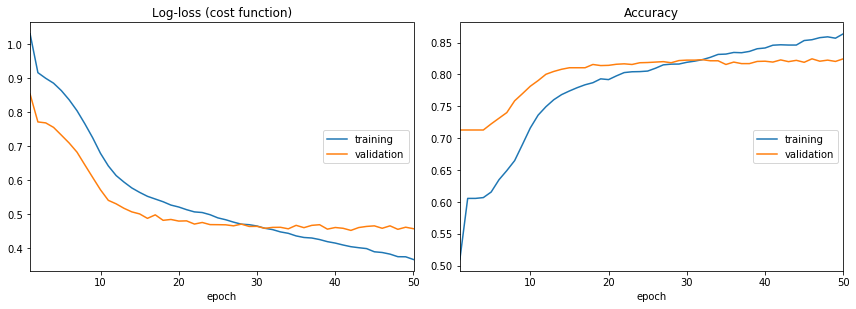

In [134]:
h = History()
model.fit(X_em, Y,
          epochs=50, batch_size=500, verbose=0, callbacks=[h, PlotLossesKeras()],
          validation_split=0.2)

In [135]:
h.history['val_acc'][-1]

0.8244535586710184